#**MINI CHALLENGE**

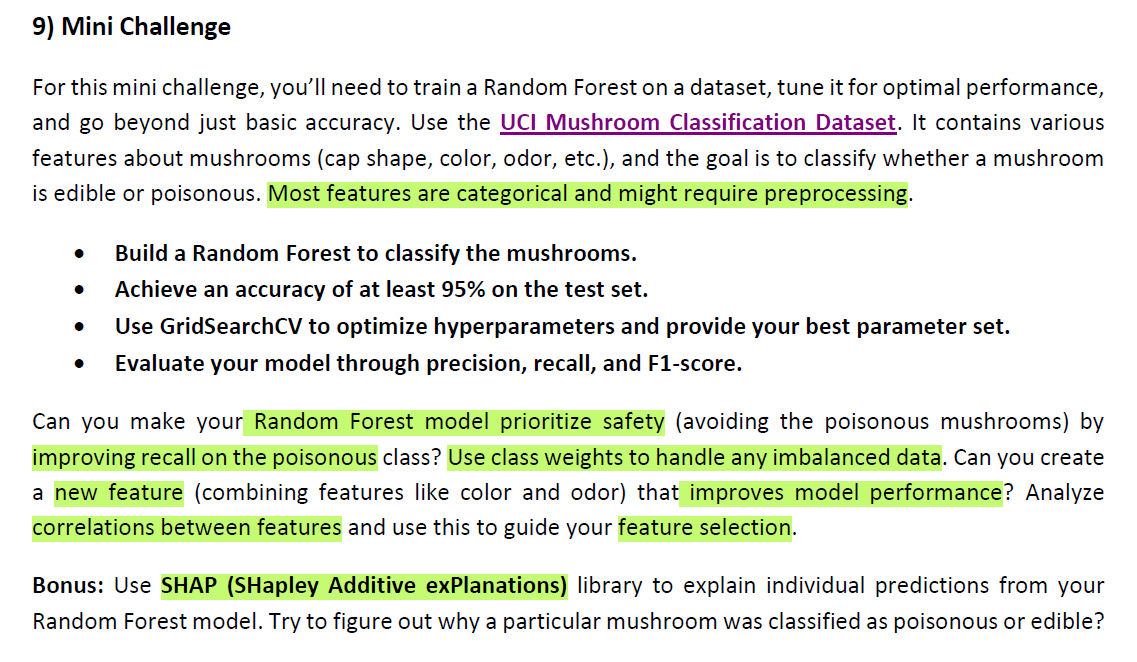

## Importing the essential libraries

In [ ]:
# importing packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import graphviz
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import xgboost as xgb
# from sklearn.metrics import plot_roc_curve, auc
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

### **Helper Functions**

In [ ]:
def model_predictions(model, X_train, X_test, y_train, y_test, df, model_name):
    """Function to fit model to training data and generate predictions.
    Another function, performance_metrics_recorder, is called to record the results
    of the predictions to a dataframe for later analysis.

    Args:
        model (instance): An instance of a classifier model.
        X_train (pd.DataFrame): Dataframe containing training data for all columns except target.
        X_test (pd.DataFrame): Dataframe containing testing data for all columns except target.
        y_train (pd.DataFrame): Dataframe containing training data for target column.
        y_test (pd.DataFrame): Dataframe containing testing data for target column.
        df (pd.DataFrame): Dataframe to commit model scores to.
        model_name (str): Label for model name.

    Returns:
        df: Dataframe with committed model scores.
        model_confusion: Confusion matrix for predictions.
    """
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    df, model_confusion = performance_metrics_recorder(predictions, y_test, df, model_name)

    return (model, df, model_confusion)

def performance_metrics_recorder(predictions, y_test, df, model_name):
    """Helper function to record scores for model predictions in a DataFrame.

    Args:
        predictions (pd.DataFrame): Dataframe of predictions generated by classifier.
        y_test (pd.DataFrame): Dataframe containing testing data for target column.
        df (pd.DataFrame): Dataframe to commit model scores to.
        model_name (str): Label for model name.

    Returns:
        df: Dataframe with committed model scores.
        model_confusion: Confusion matrix for predictions.
    """
    model_accuracy_score = accuracy_score(y_test, predictions)
    model_precision_score = precision_score(y_test, predictions)
    model_recall_score = recall_score(y_test, predictions)
    model_f1_score = f1_score(y_test, predictions)
    model_roc_auc = roc_auc_score(y_test, predictions)
    model_confusion = confusion_matrix(y_test, predictions)

    df.loc[len(df)] = [model_name,model_accuracy_score,model_precision_score,model_recall_score,model_f1_score,model_roc_auc]

    return(df, model_confusion)

def feature_importance_visualizer(X, model, label, color=None, grid=None):
    """Helper function to visualize feature importance.

    Args:
        X (pd.DataFrame): Dataframe containing all columns except target.
        model (instance): An instance of a classifier model.
        label (str): Label for model name.
        color (str, optional): Color for bars in plot. Defaults to None.
        grid (bool, optional): Whether gridlines should be included or not. Defaults to None.
    """
    features_list = X.columns.values
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)

    plt.figure()
    plt.barh(range(len(sorted_idx)),feature_importance[sorted_idx], align='center', color=color)
    plt.yticks(range(len(sorted_idx)), features_list[sorted_idx])
    plt.xlabel('Importance')
    plt.title("Feature Importances According to " + label + " Classifier")
    if grid is True:
        plt.grid(alpha=0.5)
    plt.show()

def feature_importance_visualizer_for_nonstandards(X, model, label, color, grid=None):
    """Helper function to visualize feature importance for algorithms that do
    not support the model.feature_importances_ method.

    Args:
        X (pd.DataFrame): Dataframe containing all columns except target.
        model (instance): An instance of a classifier model.
        label (str): Label for model name.
        color (str, optional): Color for bars in plot. Defaults to None.
        grid (bool, optional): Whether gridlines should be included or not. Defaults to None.
    """
    try:
        importance = model.coef_[0]
    except:
        importance = model.coef_

    feature_importances = pd.DataFrame({
        'feature':X.columns.to_list(),
        'importance':importance.tolist()
    }).sort_values('importance',ascending=True)

    plt.barh(feature_importances['feature'],feature_importances['importance'], align='center', color=color)
    plt.xlabel('Importance')
    plt.title("Feature Importances According to " + label + " Classifier")
    if grid is True:
        plt.grid(alpha=0.5)
    plt.show()

## Importing the dataset

In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
mushroom = fetch_ucirepo(id=73)

# data (as pandas dataframes)
X = mushroom.data.features
y = mushroom.data.targets


## Understanding The Data

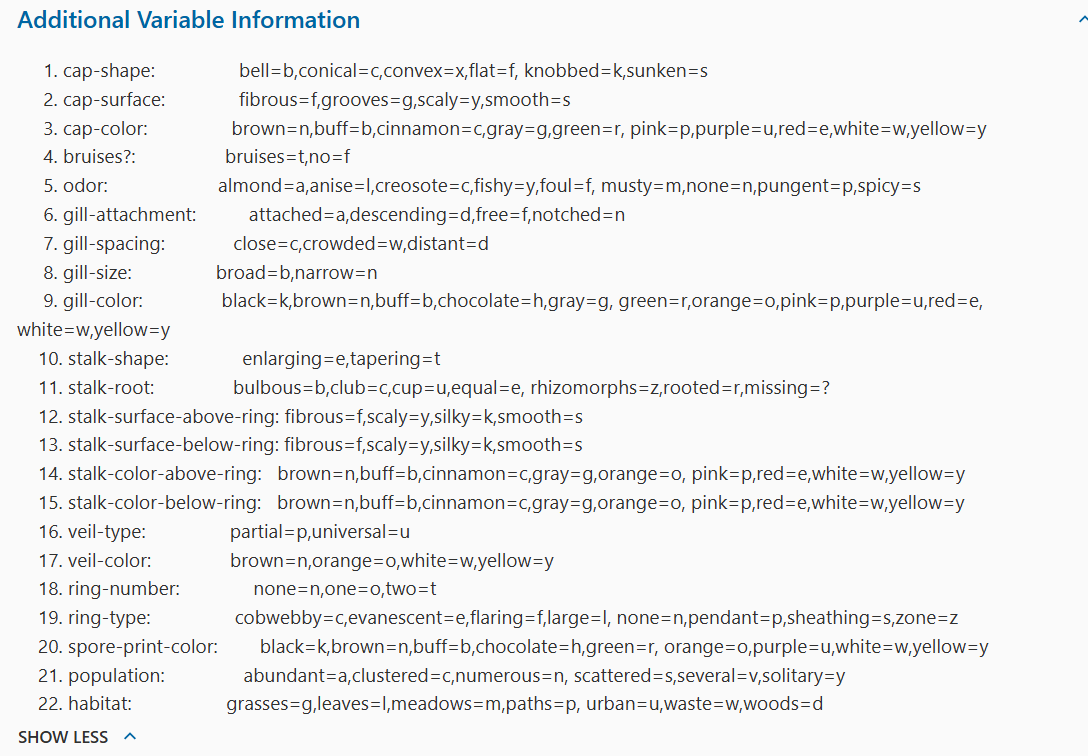

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   cap-shape                 8124 non-null   object
 1   cap-surface               8124 non-null   object
 2   cap-color                 8124 non-null   object
 3   bruises                   8124 non-null   object
 4   odor                      8124 non-null   object
 5   gill-attachment           8124 non-null   object
 6   gill-spacing              8124 non-null   object
 7   gill-size                 8124 non-null   object
 8   gill-color                8124 non-null   object
 9   stalk-shape               8124 non-null   object
 10  stalk-root                5644 non-null   object
 11  stalk-surface-above-ring  8124 non-null   object
 12  stalk-surface-below-ring  8124 non-null   object
 13  stalk-color-above-ring    8124 non-null   object
 14  stalk-color-below-ring  

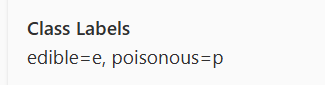

In [ ]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   poisonous  8124 non-null   object
dtypes: object(1)
memory usage: 63.6+ KB


In [ ]:
# checking for the unique values in each of the column of X
X.nunique()

,0
cap-shape,6
cap-surface,4
cap-color,10
bruises,2
odor,9
gill-attachment,2
gill-spacing,2
gill-size,2
gill-color,12
stalk-shape,2


In [ ]:
# printing the unique values for each column of X
for col in X.columns:
    print(col)
    print(X[col].unique())

cap-shape
['x' 'b' 's' 'f' 'k' 'c']
cap-surface
['s' 'y' 'f' 'g']
cap-color
['n' 'y' 'w' 'g' 'e' 'p' 'b' 'u' 'c' 'r']
bruises
['t' 'f']
odor
['p' 'a' 'l' 'n' 'f' 'c' 'y' 's' 'm']
gill-attachment
['f' 'a']
gill-spacing
['c' 'w']
gill-size
['n' 'b']
gill-color
['k' 'n' 'g' 'p' 'w' 'h' 'u' 'e' 'b' 'r' 'y' 'o']
stalk-shape
['e' 't']
stalk-root
['e' 'c' 'b' 'r' nan]
stalk-surface-above-ring
['s' 'f' 'k' 'y']
stalk-surface-below-ring
['s' 'f' 'y' 'k']
stalk-color-above-ring
['w' 'g' 'p' 'n' 'b' 'e' 'o' 'c' 'y']
stalk-color-below-ring
['w' 'p' 'g' 'b' 'n' 'e' 'y' 'o' 'c']
veil-type
['p']
veil-color
['w' 'n' 'o' 'y']
ring-number
['o' 't' 'n']
ring-type
['p' 'e' 'l' 'f' 'n']
spore-print-color
['k' 'n' 'u' 'h' 'w' 'r' 'o' 'y' 'b']
population
['s' 'n' 'a' 'v' 'y' 'c']
habitat
['u' 'g' 'm' 'd' 'p' 'w' 'l']


In [ ]:
# checking for the unique values in y
y.nunique()

,0
poisonous,2


In [ ]:
# printign the unique values of y
y['poisonous'].unique()

array(['p', 'e'], dtype=object)

## Till here I have found that all the variables are categorical

## Data Preparation & Cleaning Checklist
1.   Missing Values
2.   Duplicate and Low Variation Data
3.   Incorrect and Irrelevant Data
4.   Categorical Data
5.   Outliers
6.   Feature Scaling
7.   Feature Engineering/Selection
8.   Validation Split

## **Checking For The Missing Values and Dealing with  Categorical Data**

In [ ]:
# missing values in X
X.isnull().sum()

,0
cap-shape,0
cap-surface,0
cap-color,0
bruises,0
odor,0
gill-attachment,0
gill-spacing,0
gill-size,0
gill-color,0
stalk-shape,0


In [ ]:
# missing values in y
y.isnull().sum()

,0
poisonous,0


In [ ]:
# percentage of the missing values in stalk-root
X['stalk-root'].isnull().sum() / len(X) * 100


30.526834071885773

There is only one varible stalk-root that contains the 30.5% missing values. Here I have to decide whether to drop that missing values rows or impute them but before doing so I am analyzing its relation with all the other variables

In [ ]:
# making a copy of the orignal
X_copy = X.copy()
y_copy = y.copy()

**Label Encoding of X_copy features**

In [ ]:
# performing Label Encoding on each of the 22 features
for col in X_copy.columns:
    le = LabelEncoder()
    le.fit(X_copy[col])
    X_copy[col] = le.transform(X_copy[col])

In [ ]:
X_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   cap-shape                 8124 non-null   int64
 1   cap-surface               8124 non-null   int64
 2   cap-color                 8124 non-null   int64
 3   bruises                   8124 non-null   int64
 4   odor                      8124 non-null   int64
 5   gill-attachment           8124 non-null   int64
 6   gill-spacing              8124 non-null   int64
 7   gill-size                 8124 non-null   int64
 8   gill-color                8124 non-null   int64
 9   stalk-shape               8124 non-null   int64
 10  stalk-root                8124 non-null   int64
 11  stalk-surface-above-ring  8124 non-null   int64
 12  stalk-surface-below-ring  8124 non-null   int64
 13  stalk-color-above-ring    8124 non-null   int64
 14  stalk-color-below-ring    8124 non-null 

In [ ]:
X_copy.nunique()

,0
cap-shape,6
cap-surface,4
cap-color,10
bruises,2
odor,9
gill-attachment,2
gill-spacing,2
gill-size,2
gill-color,12
stalk-shape,2


In [ ]:
for col in X_copy.columns:
    print(col)
    print(X_copy[col].unique())

cap-shape
[5 0 4 2 3 1]
cap-surface
[2 3 0 1]
cap-color
[4 9 8 3 2 5 0 7 1 6]
bruises
[1 0]
odor
[6 0 3 5 2 1 8 7 4]
gill-attachment
[1 0]
gill-spacing
[0 1]
gill-size
[1 0]
gill-color
[ 4  5  2  7 10  3  9  1  0  8 11  6]
stalk-shape
[0 1]
stalk-root
[2 1 0 3 4]
stalk-surface-above-ring
[2 0 1 3]
stalk-surface-below-ring
[2 0 3 1]
stalk-color-above-ring
[7 3 6 4 0 2 5 1 8]
stalk-color-below-ring
[7 6 3 0 4 2 8 5 1]
veil-type
[0]
veil-color
[2 0 1 3]
ring-number
[1 2 0]
ring-type
[4 0 2 1 3]
spore-print-color
[2 3 6 1 7 5 4 8 0]
population
[3 2 0 4 5 1]
habitat
[5 1 3 0 4 6 2]


**Label Encoding Of y_copy**

In [ ]:
# performing Label Encoding
for col in y_copy.columns:
    le = LabelEncoder()
    le.fit(y_copy[col])
    y_copy[col] = le.transform(y_copy[col])

In [ ]:
y_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   poisonous  8124 non-null   int64
dtypes: int64(1)
memory usage: 63.6 KB


In [ ]:
y_copy.nunique()

,0
poisonous,2


In [ ]:
y_copy['poisonous'].unique()

array([1, 0])

In [ ]:
# counting 0 and 1
y_copy['poisonous'].value_counts()

,count
poisonous,
0,4208
1,3916


In [ ]:
y['poisonous'].value_counts()

,count
poisonous,
e,4208
p,3916


class 1 for poisonous
class 0 for edible or non poisonous

In [ ]:
# finding the relation of the stalk-root with all the other variables
X_copy['stalk-root'].value_counts()


,count
stalk-root,
0,3776
4,2480
2,1120
1,556
3,192


In [ ]:
X['stalk-root'].value_counts()

,count
stalk-root,
b,3776
e,1120
c,556
r,192


In [ ]:
X_copy.shape

(8124, 22)

In [ ]:
# finding the null rows
X_copy[X_copy['stalk-root'].isnull()]


,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat


In [ ]:
# findign relation of stalk-root with all the other feature and target column
X_copy['stalk-root'].corr(y_copy['poisonous'])

0.16797528192011815

## **Multicollinearity Checking**

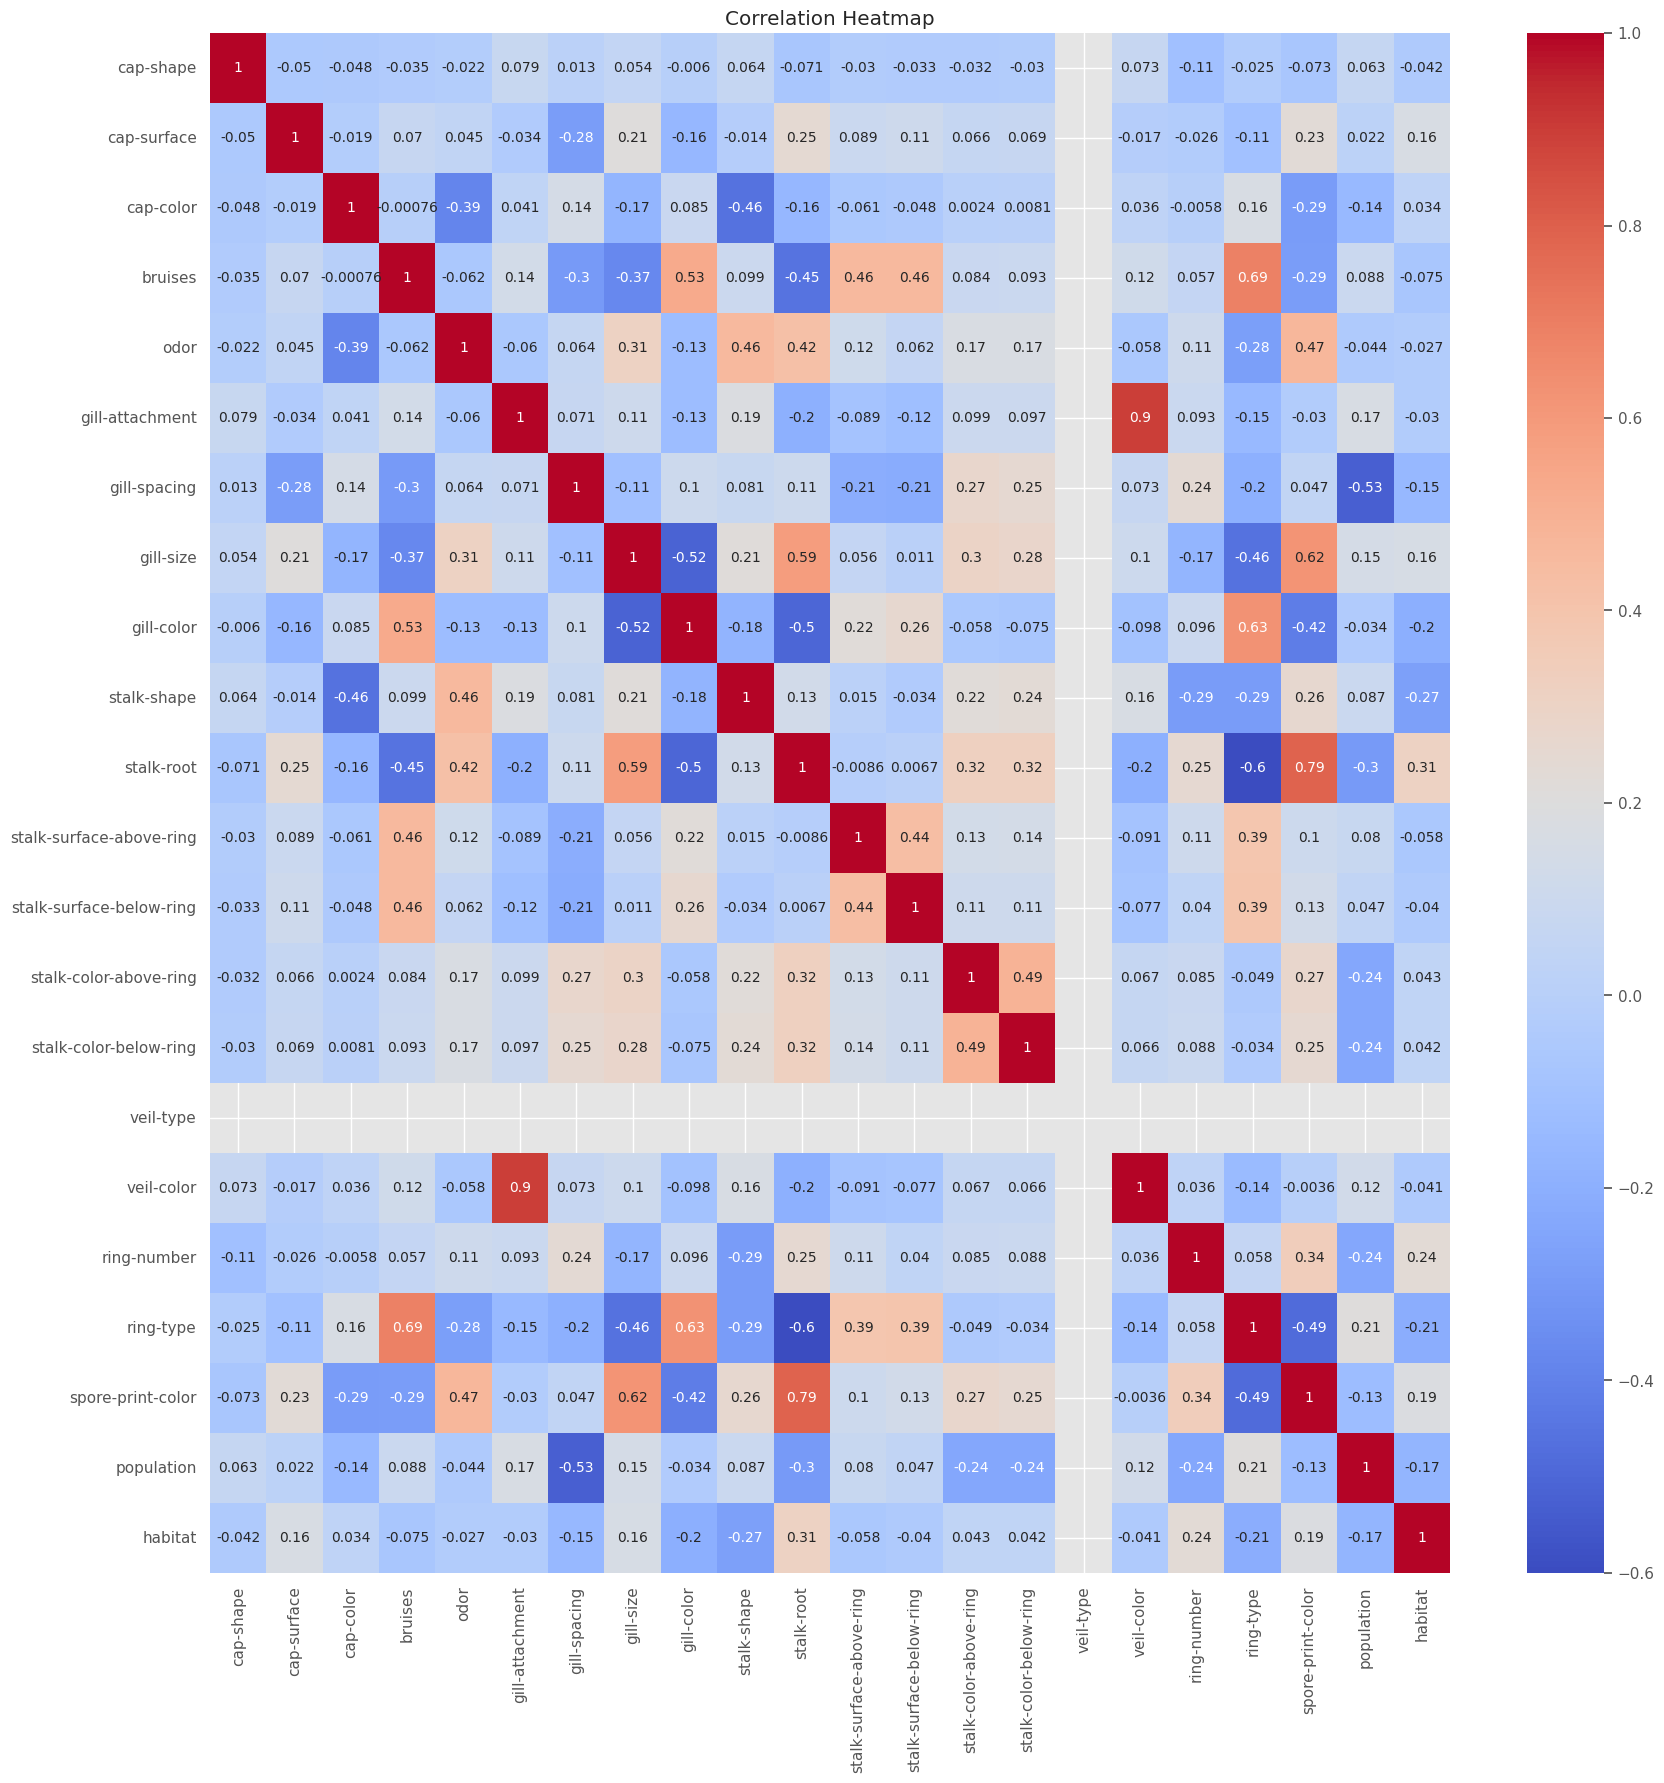

In [ ]:
# correlation matrix
corr = X_copy.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr, annot=True , cmap= 'coolwarm')
plt.title('Correlation Heatmap')
plt.show()


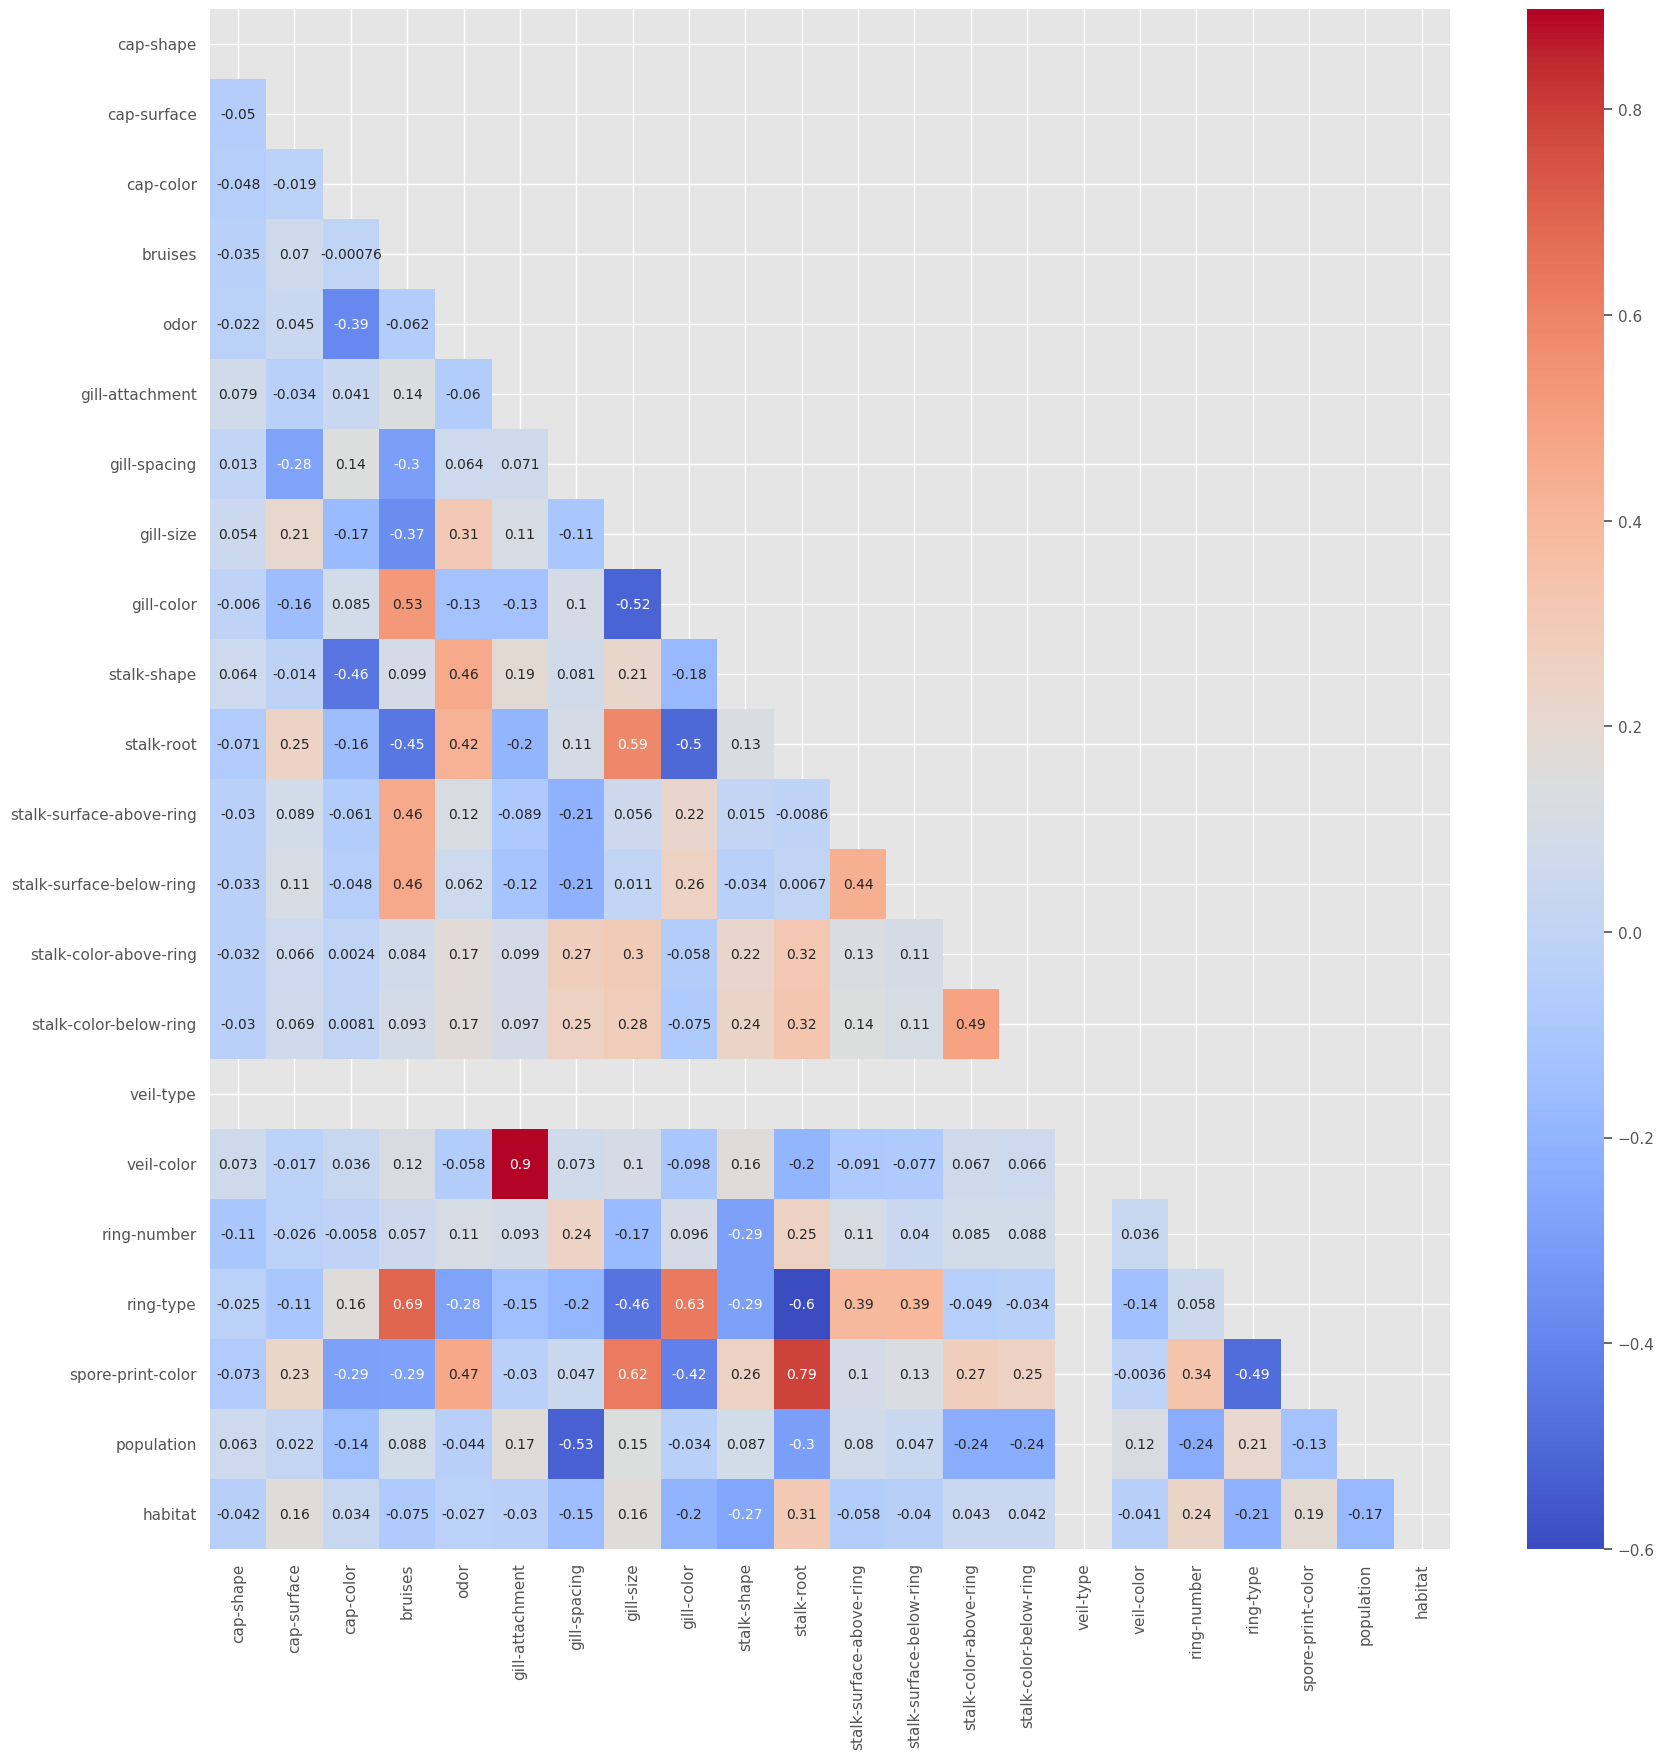

In [ ]:
# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(20, 20))
# masking the upper triagle repleated values
masking = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, mask= masking, cmap='coolwarm')
plt.show()

In [ ]:
# printing the values of the veil-type
X['veil-type'].unique()

array(['p'], dtype=object)

In [ ]:
X_copy['veil-type'].value_counts()

,count
veil-type,
0,8124


**dropping the veil-type**

In [ ]:
# dropping the veil-type
X_copy.drop('veil-type', axis=1, inplace=True)

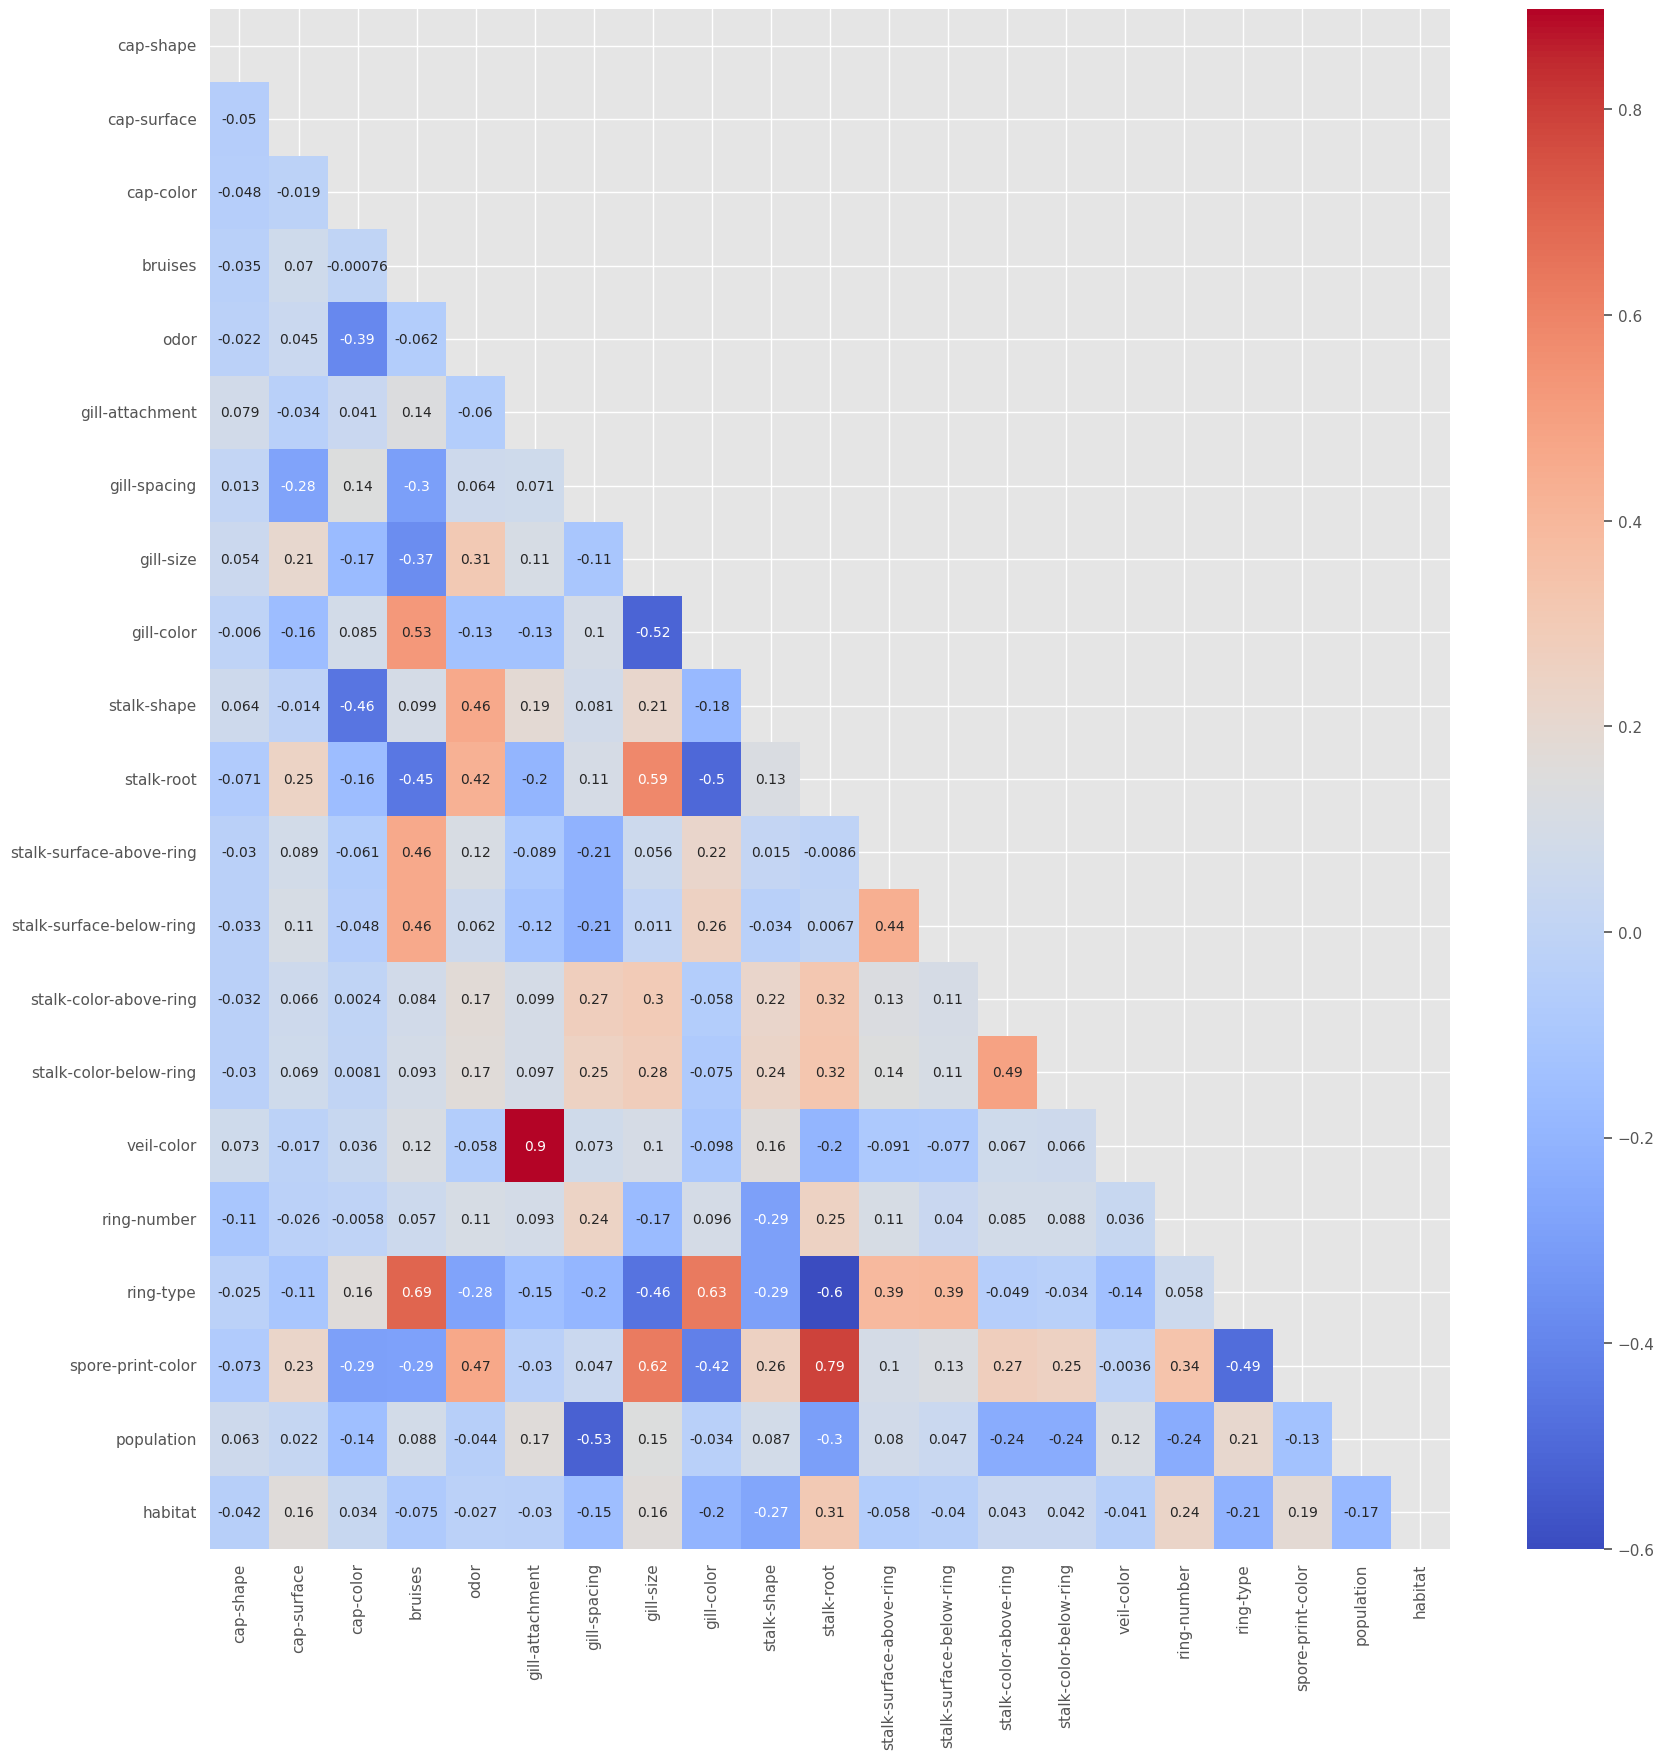

In [ ]:
# redraw corr
corr = X_copy.corr()
plt.figure(figsize=(20, 20))
# masking the upper triagle repleated values
masking = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, mask= masking, cmap='coolwarm')
plt.show()

In [ ]:
X_copy.shape

(8124, 21)

In [ ]:
y_copy.shape

(8124, 1)

## **Model Building**

### **Build a Random Forest to classify the mushrooms**

Train Test Splitting

In [ ]:
# creating train/test split using 80% data for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X_copy, y_copy, test_size = 0.2, random_state = 42)

In [ ]:
# defining some empty dfs to record metrics from each model and stage of analysis
column_names = ["method","accuracy","precision","recall","f1","roc_auc"]
performance_metrics = pd.DataFrame(columns=column_names)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


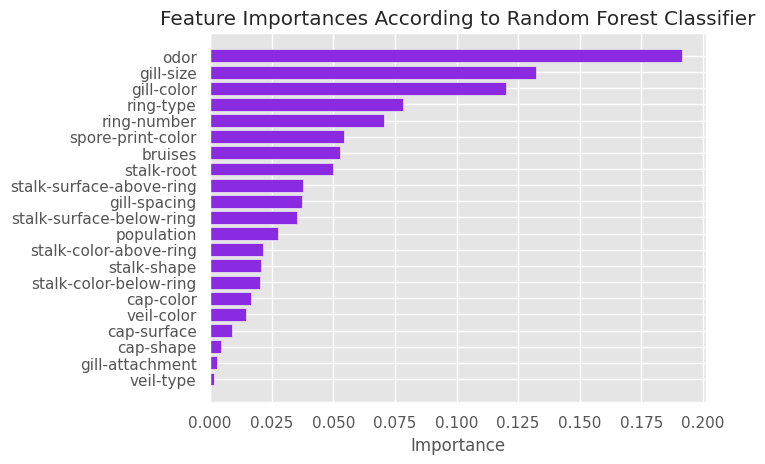

In [ ]:
# Random Forest
label = "Random Forest"
rf = RandomForestClassifier(random_state=42)
rf, performance_metrics, rf_confusion = model_predictions(rf, X_train, X_test, y_train, y_test, performance_metrics, label)
feature_importance_visualizer(X, rf, label, color="blueviolet")


### **Achieve an accuracy of at least 95% on the test set.**

In [ ]:
# print accuracy of random foreet
accuracy_score(y_test, rf.predict(X_test))

1.0

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, rf.predict(X_test)))
print("Classification Report:")
print(classification_report(y_test, rf.predict(X_test)))

Confusion Matrix:
[[843   0]
 [  0 782]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       843
           1       1.00      1.00      1.00       782

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



### **Use GridSearchCV to optimize hyperparameters and provide your best parameter set.**

In [ ]:
# using gridSearchCv to optimize hyperparameters
# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the GridSearch to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best Cross-Validation Score: 1.0


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


### **Evaluate your model through precision, recall, and F1-score.**

In [ ]:
# examining metrics dataframe
performance_metrics

,method,accuracy,precision,recall,f1,roc_auc
0,Random Forest,1.0,1.0,1.0,1.0,1.0


In [ ]:
# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, rf.predict(X_test)))
print("Classification Report:")
print(classification_report(y_test, rf.predict(X_test)))

Confusion Matrix:
[[843   0]
 [  0 782]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       843
           1       1.00      1.00      1.00       782

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



# Can you make your Random Forest model prioritize safety (avoiding the poisonous mushrooms) by improving recall on the poisonous class? Use class weights to handle any imbalanced data. Can you create a new feature (combining features like color and odor) that improves model performance? Analyze correlations between features and use this to guide your feature selection.

## **Preprocessing**

In [ ]:
# using X and y as they are the original variables
X_copy2 = X.copy()
y_copy2 = y.copy()

In [ ]:
# label encoding the all features of both X_copy2 and y_copy2
le = LabelEncoder()
for col in X_copy2.columns:
    le.fit(X_copy2[col])
    X_copy2[col] = le.transform(X_copy2[col])

In [ ]:
# label encoding the y_copy2
le = LabelEncoder()
le.fit(y_copy2['poisonous'])
y_copy2['poisonous'] = le.transform(y_copy2['poisonous'])

## **Feature Engineering**

In [ ]:
# Create new features by combining selected features
X_copy2['odor_gill_spacing'] = X_copy2['odor'] * X_copy2['gill-spacing']
X_copy2['cap_population'] = X_copy2['cap-color'] * X_copy2['population']

In [ ]:
y_copy2

,poisonous
0,1
1,0
2,0
3,1
4,0
...,...
8119,0
8120,0
8121,0
8122,1


In [ ]:
X_copy3 = X_copy2.drop(['veil-color', 'spore-print-color', 'gill-color'], axis=1)

In [ ]:
X_copy3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   cap-shape                 8124 non-null   int64
 1   cap-surface               8124 non-null   int64
 2   cap-color                 8124 non-null   int64
 3   bruises                   8124 non-null   int64
 4   odor                      8124 non-null   int64
 5   gill-attachment           8124 non-null   int64
 6   gill-spacing              8124 non-null   int64
 7   gill-size                 8124 non-null   int64
 8   stalk-shape               8124 non-null   int64
 9   stalk-root                8124 non-null   int64
 10  stalk-surface-above-ring  8124 non-null   int64
 11  stalk-surface-below-ring  8124 non-null   int64
 12  stalk-color-above-ring    8124 non-null   int64
 13  stalk-color-below-ring    8124 non-null   int64
 14  veil-type                 8124 non-null 

In [ ]:
# splitting
X_train, X_test, y_train, y_test = train_test_split(X_copy3, y_copy2, test_size=0.2, random_state=42)

# Initialize the model with class weights
model = RandomForestClassifier(random_state=42, class_weight={0: 1, 1: 2})

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# GridSearchCV for hyperparameter tuning, focusing on recall
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='recall', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate on the test set
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Edible', 'Poisonous']))

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


              precision    recall  f1-score   support

      Edible       1.00      1.00      1.00       843
   Poisonous       1.00      1.00      1.00       782

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



# **Bonus: Use SHAP (SHapley Additive exPlanations) library to explain individual predictions from your Random Forest model. Try to figure out why a particular mushroom was classified as poisonous or edible**

In [ ]:
!pip install shaP

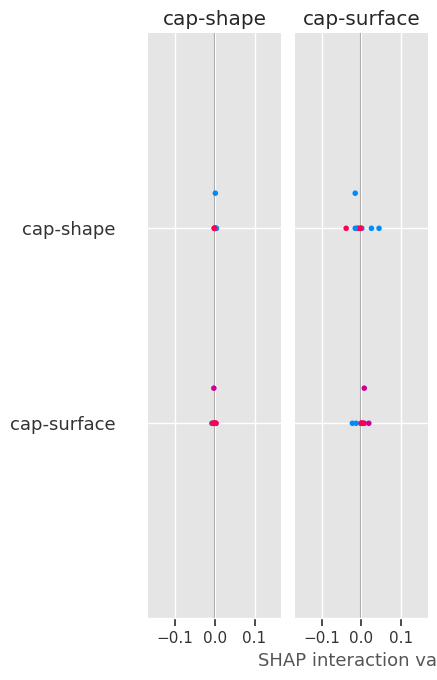

In [ ]:
import shap

# Initialize SHAP explainer with the best model
explainer = shap.TreeExplainer(best_model)

# Select a subset of data for interpretation
sample = X_test.iloc[:10]

# Calculate SHAP values
shap_values = explainer.shap_values(sample)

# Plot SHAP summary for the poisonous class (class 1)
shap.summary_plot(shap_values, sample)


# Discussion and Conclusion on Model Performance

**Discussion**:
The notebook evaluates multiple ensemble methods for binary classification tasks, specifically on breast cancer and mushroom datasets. Bagging with Decision Trees and Random Forest with class weighting and hyperparameter tuning are utilized to improve model robustness and handle class imbalance.

1. **Bagging Model**: The Bagging Classifier with Decision Trees performed effectively on the breast cancer dataset. This model’s strength lies in reducing variance, making it robust to overfitting, particularly useful given the high-dimensional nature of the dataset. However, bagging generally may not significantly improve model accuracy if the base learners are highly accurate.

2. **Random Forest Model with Class Weights**: For the mushroom dataset, where class imbalance impacts model performance, the Random Forest model was optimized using class weights and a GridSearchCV for hyperparameter tuning. Emphasizing recall in the scoring metric aligns with prioritizing sensitivity over specificity, which is crucial in domains where false negatives carry significant consequences.

3. **Interpretability**: SHAP values were applied to interpret the Random Forest model, revealing feature importance and aiding in understanding the decision boundaries of the model, particularly in identifying poisonous versus edible mushrooms.

**Conclusion**:
The ensemble methods applied in this notebook demonstrate strong performance across both datasets, with each method chosen to address specific challenges like class imbalance and feature interaction. Bagging improved model stability, while Random Forest, with optimized hyperparameters and class weighting, demonstrated high recall, reducing the likelihood of critical misclassifications. This analysis highlights the importance of model interpretability through SHAP values, which allows stakeholders to trust and verify the model's decisions. Future work could include exploring additional ensemble techniques, such as boosting, and conducting further interpretability analyses across larger samples to enhance confidence in model generalizability.